# Convolutional Variational Autoencoder

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

This notebook demonstrates how to generate images of handwritten digits by training a Variational Autoencoder ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)).



In [1]:
# to generate gifs
!pip -q install imageio

## Import TensorFlow and other libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip -q install tensorflow-gpu==1.13.1
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Wire up the generative (decoder) and inference (encoder) network

In our VAE example, we use two small ConvNets for the generative and inference network. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [5]:
class CVAE:
  def __init__(self, latent_dim):
    self.latent_dim = latent_dim

  def encode(self, x):
    with tf.variable_scope("encode"):
      out = tf.layers.conv2d(inputs=x, filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu)
      out = tf.layers.conv2d(inputs=out, filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu)
      out = tf.layers.flatten(inputs=out)
      out = tf.layers.dense(inputs=out, units=self.latent_dim * 2, activation=None)

      mean, logvar = tf.split(out , num_or_size_splits=2, axis=1)

    return mean, logvar

  def decode(self, z, apply_sigmoid=False):
    with tf.variable_scope("decode"):
      out = tf.layers.dense(inputs=z, units=7 * 7 * 32, activation=tf.nn.relu),
      out = tf.reshape(out, shape=(-1, 7, 7, 32))
      out = tf.layers.conv2d_transpose(inputs=out, filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.relu)
      out = tf.layers.conv2d_transpose(inputs=out, filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.relu)
      out = tf.layers.conv2d_transpose(inputs=out, filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation=None)

      logits = out

      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs

    return logits

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(logvar * .5) + mean

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [6]:
epochs = 5
batch_size = 100
latent_dim = 50
num_examples_to_generate = 16

In [7]:
model = CVAE(latent_dim)

with tf.variable_scope("vae", reuse=False):
  x = tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32)
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  
with tf.variable_scope("vae", reuse=True):
  y = tf.placeholder(shape=[None, latent_dim], dtype=tf.float32)
  x_y = model.decode(z=y)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [8]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
logpz = log_normal_pdf(z, 0., 0.)
logqz_x = log_normal_pdf(z, mean, logvar)
loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer = tf.train.AdamOptimizer(1e-4)
grad_update = optimizer.minimize(loss=loss)

Instructions for updating:
Use tf.cast instead.


In [9]:
def generate_and_save_images(results, epoch):
  plt.figure(figsize=(4,4))
  for i in range(len(results)):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.array(results[i, :, :, 0]), cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [10]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
y_fixed = np.random.normal(size=[num_examples_to_generate, latent_dim])

In [11]:
def train(sess):
  x_y_res = sess.run(fetches=x_y, feed_dict={y: y_fixed})
  generate_and_save_images(x_y_res, epoch=0)
  for epoch in range(1, epochs + 1):
    start_time = time.time()
    rand_idx = np.random.permutation(len(train_images))
    for step in range(0, len(rand_idx), batch_size):
      cur_data = train_images[rand_idx[step:step+batch_size]]
      sess.run(fetches=grad_update, feed_dict={x: cur_data})

    end_time = time.time()

    if epoch % 1 == 0:
      tst_loss = 0
      for tst_im in test_images:
        tst_loss += sess.run(fetches=loss, feed_dict={x: tst_im[None]})
      elbo = -tst_loss/len(test_images)
      print('Epoch: {}, Test set ELBO: {}, '
            'time elapse for current epoch {}'.format(epoch,
                                                      elbo,
                                                      end_time - start_time))
      x_y_res = sess.run(fetches=x_y, feed_dict={y: y_fixed})
      generate_and_save_images(x_y_res, epoch=epoch)

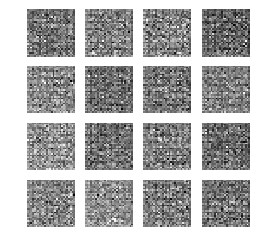

Epoch: 1, Test set ELBO: -185.96877637176513, time elapse for current epoch 3.961550712585449


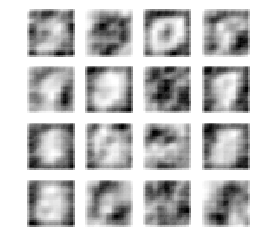

Epoch: 2, Test set ELBO: -140.3698775379181, time elapse for current epoch 3.690850257873535


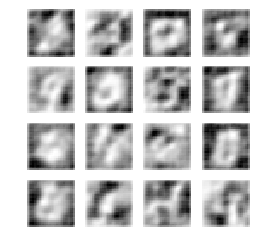

Epoch: 3, Test set ELBO: -119.68250354919434, time elapse for current epoch 3.691814661026001


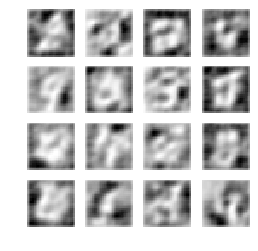

Epoch: 4, Test set ELBO: -109.99490442047119, time elapse for current epoch 3.7083234786987305


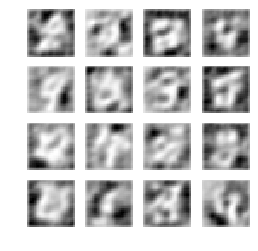

Epoch: 5, Test set ELBO: -104.40411974220275, time elapse for current epoch 3.69047474861145


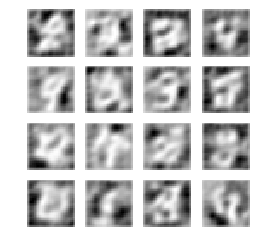

In [12]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  train(sess)

### Display an image using the epoch number

In [13]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

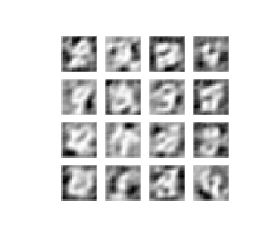

In [14]:
plt.imshow(display_image(5))
plt.axis('off')# Display images

### Generate a GIF of all the saved images.

In [15]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [16]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)